In [8]:
import os
import numpy as np
import sys
import pandas as pd
import glob
import matplotlib.pyplot as plt
import stumpy
import numpy as np
import matplotlib.pyplot as plt

auxiliary_codes_path =  ".." + os.sep + "codigo_auxiliares"
sys.path.append(auxiliary_codes_path)
import essencials as es

from sklearn.preprocessing import StandardScaler

In [9]:
plt.rcParams['font.size'] = 10
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

In [10]:
baseDir = os.path.join('..', 'Dataset')

# Seach pacth of MEASURE files
MAIN_LIST_MEASURE = []

MEASURE_FILE_PATH = 'VD_WORDS_OCCURRENCE.CSV'

MAIN_LIST_MEASURE_local = []

# B1.2 - Collect in YT
baseDir_yt = os.path.join(baseDir, 'YT-Online')

# Call the basic function
MAIN_LIST_MEASURE_yt = es.list_scan_from_path (baseDir_yt, MEASURE_FILE_PATH)

# Join the Two Lists
MAIN_LIST_MEASURE = MAIN_LIST_MEASURE_local + MAIN_LIST_MEASURE_yt

In [11]:
SUB_FILE_NAME = 'VD_SUBTITLES.CSV'
MAIN_LIST_MEASURE_FILTER = []
for current_path in MAIN_LIST_MEASURE:
    path = es.collect_current_path(current_path)
    check, _ = es.check_file_exist(path, SUB_FILE_NAME)
    if check:
        MAIN_LIST_MEASURE_FILTER.append(current_path)  

## Reading all Word Occurrence files

In [12]:
VD_INFO_DT = 'VD_INFO.CSV'
TOTAL = pd.DataFrame()
for current_path in MAIN_LIST_MEASURE_FILTER:
    path_dir = es.collect_current_path(current_path)
    vd_info_path = os.path.join(path_dir, VD_INFO_DT)
    
    vd_info = pd.read_csv(vd_info_path)
    vd_info.drop(columns=['Unnamed: 0'], inplace=True)
    video_id =  vd_info.video_id[0]
    
    try:
        VD_WORDS_OCCURRENCE = pd.read_csv(current_path)
        if 'Unnamed: 0' in VD_WORDS_OCCURRENCE.columns:
            VD_WORDS_OCCURRENCE.drop(columns=['Unnamed: 0'], inplace=True)
            
        VD_WORDS_OCCURRENCE.insert(0, 'video_id', video_id)
        TOTAL = pd.concat([TOTAL, VD_WORDS_OCCURRENCE])
        if VD_WORDS_OCCURRENCE.empty:
            print("O arquivo CSV está vazio.", current_path)
    except pd.errors.EmptyDataError:
        print("O arquivo CSV está vazio.", current_path)       

O arquivo CSV está vazio. ../Dataset/YT-Online/VD_Y_0000000001/VD_WORDS_OCCURRENCE.CSV
O arquivo CSV está vazio. ../Dataset/YT-Online/VD_Y_0000000012/VD_WORDS_OCCURRENCE.CSV
O arquivo CSV está vazio. ../Dataset/YT-Online/VD_Y_0000000017/VD_WORDS_OCCURRENCE.CSV
O arquivo CSV está vazio. ../Dataset/YT-Online/VD_Y_0000000018/VD_WORDS_OCCURRENCE.CSV
O arquivo CSV está vazio. ../Dataset/YT-Online/VD_Y_0000000022/VD_WORDS_OCCURRENCE.CSV


## Setting word to carry out the search flow

In [13]:
word ='INSIRA_SUA_PALAVRA_AQUI'.upper()

FILTER = TOTAL[TOTAL['selected_word'] == word]
print(f'The Word "{word}" has {len(FILTER)} occurrence')

The Word "PRESENTATION" has 17 occurrence


## Count word frequency in each video

In [14]:
count_id = FILTER.video_id.value_counts()
FREQUENCY_DT = pd.DataFrame({'video_id': count_id.index, 'amount': count_id.values})

## Setting video_id to show the setences in subtitle

In [15]:
video_id = insira_o_id_do_video_aqui

FILTER_ID = FILTER.query(f'video_id=={video_id}')
FILTER_ID = FILTER_ID.rename_axis('id_sentence') 

,video_id,selected_word,start_time_seconds,end_time_seconds,ini_frame,end_frame,text
id_sentence,,,,,,,
0,11,PRESENTATION,3.179,7.410,76,178,PRESENTATION AND I TALKED ABOUT THE
1,11,PRESENTATION,22.800,26.580,546,638,PRESENTATION SKILLS I'LL TEACH YOU HOW
2,11,PRESENTATION,122.040,125.729,2926,3015,GIVING THE PRESENTATION OF WHY I'M
3,11,PRESENTATION,162.500,167.060,3896,4006,SECTIONS OF THAT PRESENTATION TO GIVE
4,11,PRESENTATION,191.060,195.769,4580,4694,YOUR PRESENTATION IS LESS THAN 60


## Plotting all all sequences of the selected word

In [16]:
id_sentence = list(FILTER_ID.index)
id_sentence

[0, 1, 2, 3, 4]

In [17]:
# READ VD BLOCKS_WORDS
# Generate the path of the video in dataset
VD_BLOCKS_FILE_NAME = 'VD_BLOCKS_WORDS_OCCURRENCE.CSV'
path_video = os.path.join(baseDir_yt, f'VD_Y_{video_id:010d}', VD_BLOCKS_FILE_NAME)
VD_BLOCKS_WORDS = pd.read_csv(path_video)
VD_BLOCKS_WORDS = VD_BLOCKS_WORDS.rename(columns={'Unnamed: 2': 'frame'})

início e fim de cada amostra da palavra presentation:
- 0 - 548:568
- 1 - 77:97
- 2 - 2936:2955
- 3 - 3912:3930
- 4 - 4583:4599

In [18]:
frames_word = {'0': [78,98],
            '1':[549,568],
            '2': [2936,2955],
            '3': [3912,3930],
            '4': [4583,4599]}

ALL_WORD_DT = pd.DataFrame()

for id in id_sentence:
    VD_BLOCKS_WORDS_FILTER = VD_BLOCKS_WORDS.query(f'block_id=={id}').reset_index(drop=True)

    # Check if there is a discontinuity in the sentence
    if VD_BLOCKS_WORDS_FILTER.loc[1:,'gap'].any()==1:
        print(f'A time series exhibits a discontinuity: {id}')
    else:
        SENTENCE_DT = VD_BLOCKS_WORDS_FILTER.iloc[:,[0]+[2]+[4] + list(range(7, 23))]
        
        # Corta palavra
        frame_begin, frame_end = frames_word[str(id)]
        WORD_DT = SENTENCE_DT.query(f'frame_seq >= {frame_begin} & frame_seq <= {frame_end}')
        ALL_WORD_DT = pd.concat([ALL_WORD_DT, WORD_DT])

In [19]:
new_measures = {'m1': 'b1', 
             'm3': 'b2',
             'm5': 'b3',
             'm13': 'b4',
             'm4': 'b5'}

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

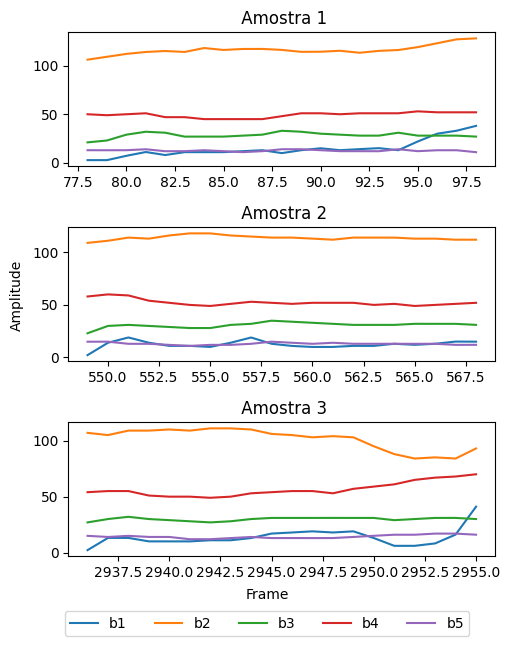

In [20]:
# Criar um objeto StandardScaler
scaler = StandardScaler()
id_sentence = [0,1,2]
title = 'Amostra'
reference_measures = ['b1', 'b2', 'b3', 'b4', 'b5']

ALL_WORD_DT = ALL_WORD_DT.rename(columns=new_measures)
lines=[]

fig, axs = plt.subplots(len(id_sentence), 1, figsize=(5, 6))
for i, id in enumerate(id_sentence):
    dt = ALL_WORD_DT.query(f'block_id=={id}').reset_index(drop=True)
    y = dt.frame_seq.values
    dt = dt[reference_measures]

    # Criar um novo DataFrame com os dados normalizados
    line = axs[i].plot(y, dt, label=dt.columns)
    lines.append(line)
    axs[i].set_title(f' {title} {i+1}')
    
# Adicionar uma legenda fora dos subplots
fig.legend(lines[0], reference_measures, loc='outside lower center', bbox_to_anchor=(0.5, -0.08), ncol=len(dt.columns))
fig.text(0.5, 0, 'Frame', ha='center', va='center')
fig.text(0, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical')

plt.tight_layout()
plt.savefig(f'{word}_all_measures.png', bbox_inches='tight')
plt.show()